<a href="https://colab.research.google.com/github/KimJuHan/pytorch_tutorial/blob/master/kaggle_housePrice_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My\ Drive/data/house_price_regression

/content/gdrive/My Drive/data/house_price_regression


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
from torch import nn, optim, cuda
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [12]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
print(train_data.shape)
print(test_data.shape)
# train data + test data
data = train_data.append(test_data, ignore_index=True)
# categorical variable => dummy variable
# get_dummies() : series 객체와 dataFrame 객체를 인자로 받을 수 있음
# dataFrame 객체를 인자로 받는 경우, numerical value를 갖는 칼럼은 더미값생성을 하지 않는다.
# dummy_na 인자 : categorical value값이 null인 경우도 칼럼을 생성한다.
# drop_first 인자 : categorical value값 중 첫번째 값을 버림
data = pd.get_dummies(data, dummy_na=True, drop_first=True)
data.drop('Id', axis=1, inplace=True)

# any() : 인자로 axis를 가지는데, 디폴트값은 0이다
# 마스킹 테이블에 대하여 칼럼별로 False가 값으로 들어있는 테이블을 체크한다. 
# 만약 인스턴스가 일반 리스트인 경우, 모든 원소에 대해 검사한다. 
print(data.isnull().values.any())
print(data.isnull().any(axis=1))
# na값이 상당히 많은 것을 확인할 수 있다. 
data[data.isnull().any(axis=1)]

# 칼럼별로 메디안값을 계산한 series객체를 반환한다. 
data.median()
# 데이터 전처리
# fillna 인자로 series객체를 주면, 해당 칼럼에 해당하는 series객체의 값을 넣어준다.
data.fillna(data.median(), inplace=True)
columns = data.columns
data.isnull().values.any()

# 데이터 전처리 복구를 위하여 min, max, mean 저장
maxSalePrice = data['SalePrice'].max()
minSalePrice = data['SalePrice'].min()
meanSalePrice = data['SalePrice'].mean()
X = data['SalePrice']
stdSalePrice = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min

print(maxSalePrice)
print(minSalePrice)
print(meanSalePrice)
print(stdSalePrice)

scaler = MinMaxScaler()
# 데이터 정규화
data = pd.DataFrame(scaler.fit_transform(data), columns=columns)
# 데이터 복원 예시
test = pd.DataFrame(scaler.inverse_transform(data), columns=columns)

train_data = data.iloc[:1461]
test_data = data.iloc[1461:]

(1460, 81)
(1459, 80)
True
0       False
1       False
2       False
3       False
4       False
        ...  
2914     True
2915     True
2916     True
2917     True
2918     True
Length: 2919, dtype: bool
755000.0
34900.0
171963.6676944159
0       0.241078
1       0.203583
2       0.261908
3       0.145952
4       0.298709
          ...   
2914    0.177892
2915    0.177892
2916    0.177892
2917    0.177892
2918    0.177892
Name: SalePrice, Length: 2919, dtype: float64


In [0]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(288, 144)
    self.fc2 = nn.Linear(144, 72)
    self.fc3 = nn.Linear(72, 18)
    self.fc4 = nn.Linear(18, 1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    return x

In [0]:
class houseDataset(Dataset):
  def __init__(self, train=True):
    if train:
      data = train_data.copy()
    else:
      data = test_data.copy()
    self.len = data.shape[0]
    self.x_data = torch.from_numpy(data.drop('SalePrice', axis=1).values).float()
    self.y_data = torch.from_numpy(data['SalePrice'].values).view(-1,1).float()

  def __getitem__(self, index):
    return self.x_data[index], self.y_data[index]

  def __len__(self):
    return self.len

dataset = houseDataset(train=True)
trainset = houseDataset(train=False)
train_loader = DataLoader(dataset=dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=2)
test_loader = DataLoader(dataset=trainset,
                         batch_size=len(trainset),
                         num_workers=2)

In [7]:
model = Model()
device = 'cuda' if cuda.is_available() else 'cpu'
print(f'Training MNIST Model on {device}\n{"=" * 44}')
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

Training MNIST Model on cpu


Train Epoch: 0 | Batch Status: 0/1461 (0%) | Loss: 0.007162
Train Epoch: 0 | Batch Status: 320/1461 (22%) | Loss: 0.004275
Train Epoch: 0 | Batch Status: 640/1461 (43%) | Loss: 0.012006
Train Epoch: 0 | Batch Status: 960/1461 (65%) | Loss: 0.007873
Train Epoch: 0 | Batch Status: 1280/1461 (87%) | Loss: 0.006103
Training time: 0m 0s
Train Epoch: 1 | Batch Status: 0/1461 (0%) | Loss: 0.008473
Train Epoch: 1 | Batch Status: 320/1461 (22%) | Loss: 0.013878
Train Epoch: 1 | Batch Status: 640/1461 (43%) | Loss: 0.006601
Train Epoch: 1 | Batch Status: 960/1461 (65%) | Loss: 0.010333
Train Epoch: 1 | Batch Status: 1280/1461 (87%) | Loss: 0.008536
Training time: 0m 0s
Train Epoch: 2 | Batch Status: 0/1461 (0%) | Loss: 0.009824
Train Epoch: 2 | Batch Status: 320/1461 (22%) | Loss: 0.006485
Train Epoch: 2 | Batch Status: 640/1461 (43%) | Loss: 0.011863
Train Epoch: 2 | Batch Status: 960/1461 (65%) | Loss: 0.007484
Train Epoch: 2 | Batch Status: 1280/1461 (87%) | Loss: 0.013925
Training time: 0m 0

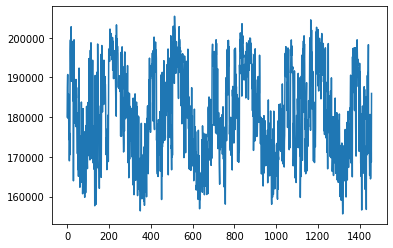

Total Time: 0m 19s
Model was trained on cpu!


In [14]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} | Batch Status: {}/{} ({:.0f}%) | Loss: {:.6f}'.format(
          epoch, batch_idx*len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()
      ))

def test():
  model.eval()
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
    result = output*(maxSalePrice-minSalePrice) + minSalePrice
    print(result)
    plt.plot(result)
    plt.show()
  
since = time.time()
for epoch in range(100):
    epoch_start = time.time()
    train(epoch)
    m, s = divmod(time.time() - epoch_start, 60)
    print(f'Training time: {m:.0f}m {s:.0f}s')
test()

m, s = divmod(time.time() - since, 60)
print(f'Total Time: {m:.0f}m {s:.0f}s\nModel was trained on {device}!')